In [10]:
!git clone https://github.com/AILab-CVC/YOLO-World

fatal: destination path 'YOLO-World' already exists and is not an empty directory.


# Zero-Shot Object Detection with YOLO-World
---

[![GitHub](https://badges.aleen42.com/src/github.svg)](https://github.com/AILab-CVC/YOLO-World)
[![arXiv](https://img.shields.io/badge/arXiv-2401.17270-b31b1b.svg)](https://arxiv.org/abs/2401.17270)
[![YouTube](https://badges.aleen42.com/src/youtube.svg)](https://youtu.be/X7gKBGVz4vs)
[![Roboflow](https://raw.githubusercontent.com/roboflow-ai/notebooks/main/assets/badges/roboflow-blogpost.svg)](https://blog.roboflow.com/what-is-yolo-world/)

YOLO-World was designed to solve a limitation of existing zero-shot object detection models: speed. Whereas other state-of-the-art models use Transformers, a powerful but typically slower architecture, YOLO-World uses the faster CNN-based YOLO architecture.

According to the paper YOLO-World reached between 35.4 AP with 52.0 FPS for the large version and 26.2 AP with 74.1 FPS for the small version. While the V100 is a powerful GPU, achieving such high FPS on any device is impressive.

![visualization results of referring object detection](https://storage.googleapis.com/com-roboflow-marketing/supervision/cookbooks/yolo-world-visualization-results-of-referring-object-detection.png)

## Before you start

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [2]:
!nvidia-smi

Sat Nov 29 10:11:07 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   51C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

**NOTE:** To make it easier for us to manage datasets, images and models we create a `HOME` constant.

In [3]:
import os
HOME = os.getcwd()
print(HOME)

/content


## Install required packages

In this guide, we utilize two Python packages: `inference`, for executing zero-shot object detection using YOLO-World, and `supervision`, for post-processing and visualizing the detected objects.

In [4]:
!pip install -q inference-gpu[yolo-world]==0.9.13

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 128.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  error: subprocess-exited-with-error
  
  × Getting requirements to build wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Getting requirements to build wheel ... error
error: subprocess-exited-with-error

× Getting requirements to build wheel did not run successfully.
│ exit code: 1
╰─> See above for output.

note: This error originates from a subprocess, and is likely not a problem with pip.


In [5]:
!pip install -q supervision==0.19.0rc3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.8/90.8 kB 6.3 MB/s eta 0:00:00


## Imports

In [7]:
!pip install inference

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.7/105.7 kB 6.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.6/68.6 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.4/99.4 kB 8.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 4.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.5/48.5 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 60.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 89.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.1/190.1 kB 16.

In [2]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 56.7 MB/s eta 0:00:00


In [3]:
import cv2
import supervision as sv

from tqdm import tqdm
from inference.models import YOLOWorld

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


## Download example data

In [4]:
!wget -P {HOME} -q https://media.roboflow.com/notebooks/examples/dog.jpeg
!wget -P {HOME} -q https://media.roboflow.com/supervision/cookbooks/yellow-filling.mp4

In [5]:
SOURCE_IMAGE_PATH = f"{HOME}/dog.jpeg"
SOURCE_VIDEO_PATH = f"{HOME}/yellow-filling.mp4"

NameError: name 'HOME' is not defined

In [12]:
SOURCE_IMAGE_PATH = "/content/{HOME}/dog.jpeg"
SOURCE_VIDEO_PATH = "/content/{HOME}/yellow-filling.mp4"

**NOTE:** If you want to run the cookbook using your own file as input, simply upload video to Google Colab and replace `SOURCE_IMAGE_PATH` and `SOURCE_VIDEO_PATH` with the path to your file.

## Run Object Detection

The Inference package provides the YOLO-World model in three versions: `S`, `M`, and `L`. You can load them by defining model_id as `yolo_world/s`, `yolo_world/m`, and `yolo_world/l`, respectively. The `ROBOFLOW_API_KEY` is not required to utilize this model.







In [6]:
model = YOLOWorld(model_id="yolo_world/l")

Creating inference sessions


CLIP model loaded in 21.63 seconds


YOLO-World is a zero-shot model, enabling object detection without any training. You only need to define a prompt as a list of classes (things) you are searching for.

In [7]:
classes = ["person", "backpack", "dog", "eye", "nose", "ear", "tongue"]
model.set_classes(classes)

We perform detection on our sample image. Then, we convert the result into a [`sv.Detections`](https://supervision.roboflow.com/latest/detection/core/) object, which will be useful in the later parts of the cookbook.

In [13]:
image = cv2.imread(SOURCE_IMAGE_PATH)
results = model.infer(image)
detections = sv.Detections.from_inference(results)

The results we've obtained can be easily visualized with [`sv.BoundingBoxAnnotator`](https://supervision.roboflow.com/latest/annotators/#supervision.annotators.core.BoundingBoxAnnotator) and [`sv.LabelAnnotator`](https://supervision.roboflow.com/latest/annotators/#supervision.annotators.core.LabelAnnotator). We can adjust parameters such as line thickness, text scale, line and text color allowing for a highly tailored visualization experience.

ImportError: cannot import name 'BoundingBoxAnnotator' from 'supervision' (/usr/local/lib/python3.12/dist-packages/supervision/__init__.py)

In [17]:
BOUNDING_BOX_ANNOTATOR = sv.BoxAnnotator(thickness=2)
LABEL_ANNOTATOR = sv.LabelAnnotator(text_thickness=2, text_scale=1, text_color=sv.Color.BLACK)

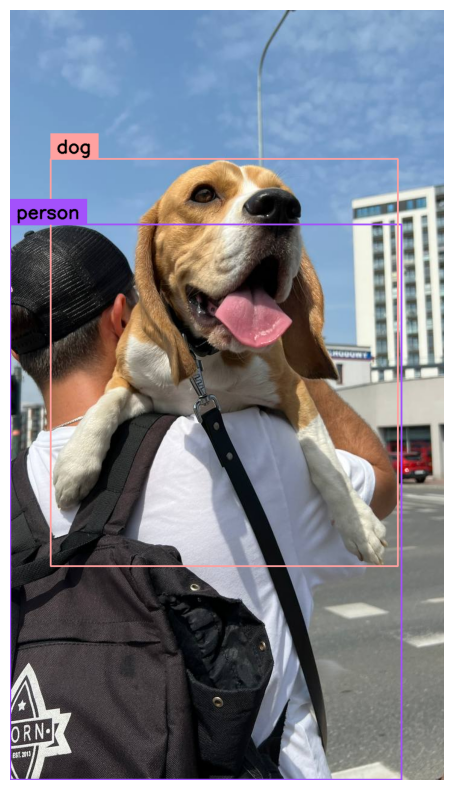

In [18]:
annotated_image = image.copy()
annotated_image = BOUNDING_BOX_ANNOTATOR.annotate(annotated_image, detections)
annotated_image = LABEL_ANNOTATOR.annotate(annotated_image, detections)
sv.plot_image(annotated_image, (10, 10))

## Adjusting Confidence Level

Note that many classes from our prompt were not detected. This is because the default confidence threshold in Inference is set to `0.5`. Let's try significantly lowering this value. We've observed that the confidence returned by YOLO-World is significantly lower when querying for classes outside the [COCO](https://universe.roboflow.com/microsoft/coco) dataset.

In [19]:
image = cv2.imread(SOURCE_IMAGE_PATH)
results = model.infer(image, confidence=0.003)
detections = sv.Detections.from_inference(results)

By default, `sv.LabelAnnotator` displays only the names of objects. To also view the confidence levels associated with each detection, we must define custom `labels` and pass them to `sv.LabelAnnotator`.

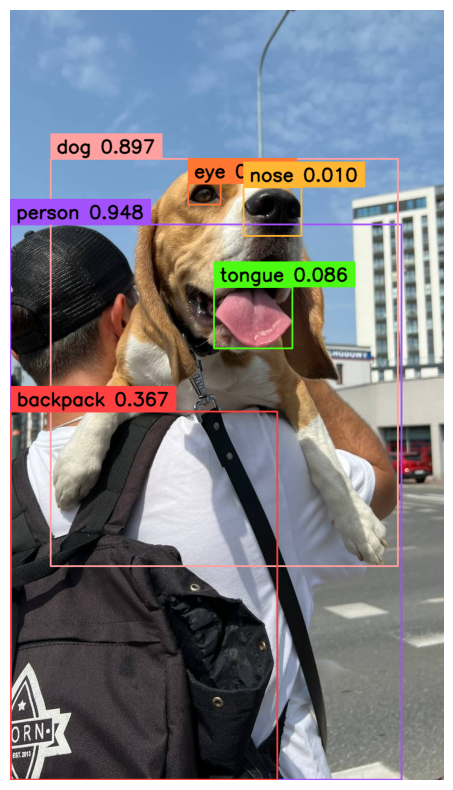

In [20]:
labels = [
    f"{classes[class_id]} {confidence:0.3f}"
    for class_id, confidence
    in zip(detections.class_id, detections.confidence)
]

annotated_image = image.copy()
annotated_image = BOUNDING_BOX_ANNOTATOR.annotate(annotated_image, detections)
annotated_image = LABEL_ANNOTATOR.annotate(annotated_image, detections, labels=labels)
sv.plot_image(annotated_image, (10, 10))

## Using Non-Max Suppression (NMS) to Eliminate Double Detections

To eliminate duplicates, we will use [Non-Max Suppression (NMS)](https://blog.roboflow.com/how-to-code-non-maximum-suppression-nms-in-plain-numpy). NMS evaluates the extent to which detections overlap using the Intersection over Union metric and, upon exceeding a defined threshold, treats them as duplicates. Duplicates are then discarded, starting with those of the lowest confidence. The value should be within the range `[0, 1]`. The smaller the value, the more restrictive the NMS.







In [21]:
image = cv2.imread(SOURCE_IMAGE_PATH)
results = model.infer(image, confidence=0.003)
detections = sv.Detections.from_inference(results).with_nms(threshold=0.1)

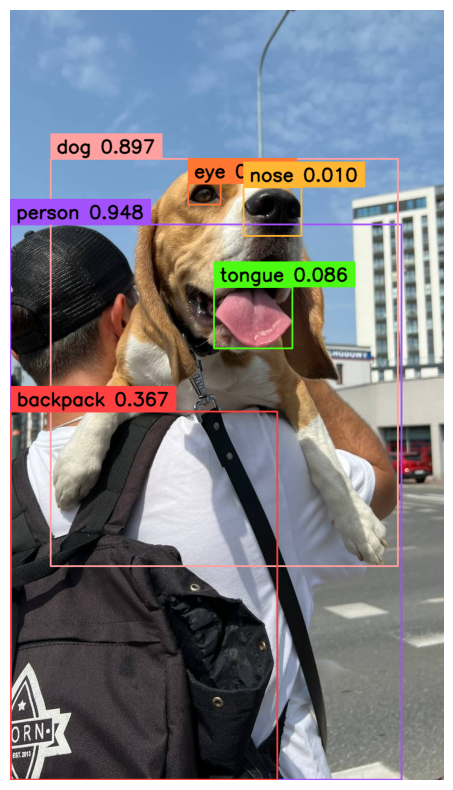

In [22]:
labels = [
    f"{classes[class_id]} {confidence:0.3f}"
    for class_id, confidence
    in zip(detections.class_id, detections.confidence)
]

annotated_image = image.copy()
annotated_image = BOUNDING_BOX_ANNOTATOR.annotate(annotated_image, detections)
annotated_image = LABEL_ANNOTATOR.annotate(annotated_image, detections, labels=labels)
sv.plot_image(annotated_image, (10, 10))

## Video Processing

The [`get_video_frames_generator`](https://supervision.roboflow.com/latest/utils/video/#supervision.utils.video.get_video_frames_generator) enables us to easily iterate over video frames. Let's create a video generator for our sample input file and display its first frame on the screen.

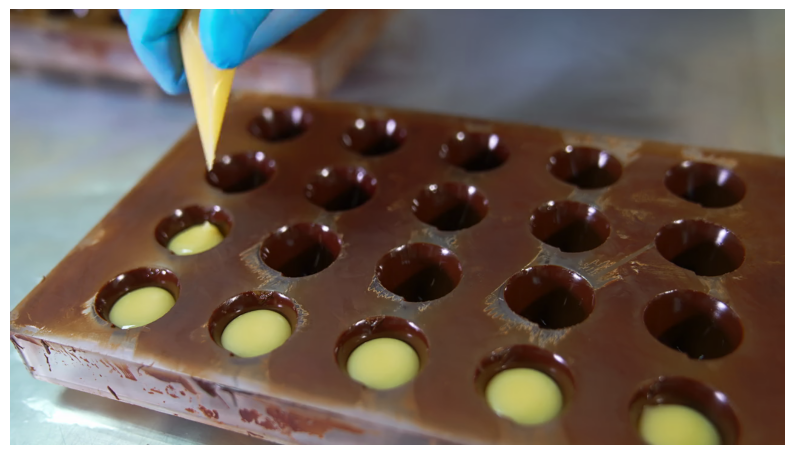

In [23]:
generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
frame = next(generator)

sv.plot_image(frame, (10, 10))

Let's update our list of classes. This time we are looking for `yellow filling`. The rest of the code performing detection, filtering and visualization remains unchanged.

In [24]:
classes = ["yellow filling"]
model.set_classes(classes)

In [25]:
results = model.infer(frame, confidence=0.002)
detections = sv.Detections.from_inference(results).with_nms(threshold=0.1)

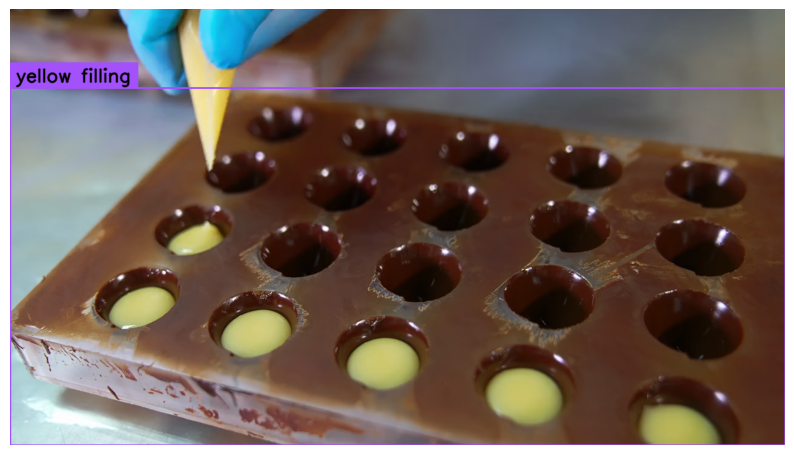

In [26]:
annotated_image = frame.copy()
annotated_image = BOUNDING_BOX_ANNOTATOR.annotate(annotated_image, detections)
annotated_image = LABEL_ANNOTATOR.annotate(annotated_image, detections)
sv.plot_image(annotated_image, (10, 10))

## Filtering Detectuions by Area

Our prompt allowed us to locate all filled holes, but we also accidentally marked the entire high-level element. To address this issue, we'll filter detections based on their relative area in relation to the entire video frame. If a detection occupies more than 10% of the frame's total area, it will be discarded.

We can use [`VideoInfo.from_video_path`](https://supervision.roboflow.com/develop/utils/video/#supervision.utils.video.VideoInfo) to learn basic information about our video, such as duration, resolution, or FPS.

In [27]:
video_info = sv.VideoInfo.from_video_path(SOURCE_VIDEO_PATH)
video_info

VideoInfo(width=1280, height=720, fps=25, total_frames=442)

Knowing the frame's resolution allows us to easily calculate its total area, expressed in pixels.

In [28]:
width, height = video_info.resolution_wh
frame_area = width * height
frame_area

921600

On the other hand, by using [`sv.Detections.area`](https://supervision.roboflow.com/develop/detection/core/#supervision.detection.core.Detections.area) property, we can learn the area of each individual bounding box.

In [29]:
results = model.infer(frame, confidence=0.002)
detections = sv.Detections.from_inference(results).with_nms(threshold=0.1)
detections.area

array([ 7.5408e+05])

Now, we can combine these two pieces of information to construct a filtering condition for detections with an area greater than 10% of the entire frame.

In [30]:
(detections.area / frame_area) < 0.10

array([False])

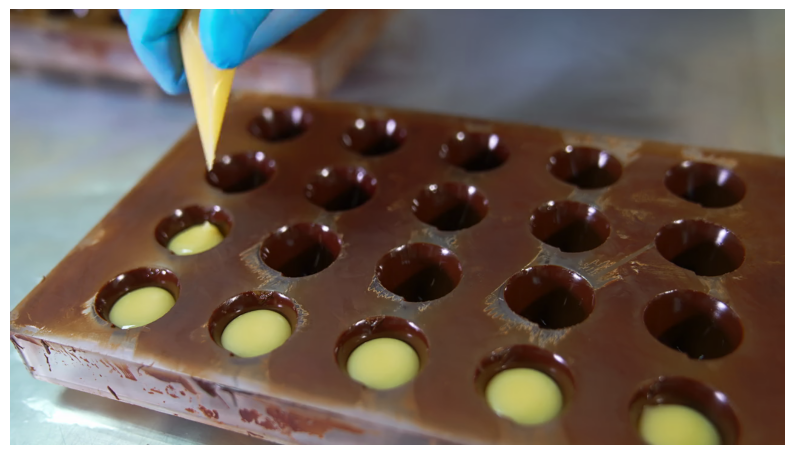

In [31]:
detections = detections[(detections.area / frame_area) < 0.10]

annotated_image = frame.copy()
annotated_image = BOUNDING_BOX_ANNOTATOR.annotate(annotated_image, detections)
annotated_image = LABEL_ANNOTATOR.annotate(annotated_image, detections)
sv.plot_image(annotated_image, (10, 10))